### How much such a not-for-profit organization pay it's top management?  Not-for-profit organizations devoted to specific causes have a huge amount of variablity (revenue, number of volunteers, ect.).  How much should not-for-profits award their top managment?
### Data source:

The data for this project was aquired from Open990(https://www.open990.org/catalog/), an organization that aggregates and provides not-for-profit tax return data made public by the IRS.  This dataset has great documentation about what the attributes mean, however this only includes data for 1 year(2016).  The organization that provides this data also provides analytics services with this data for a fee. (https://appliednonprofitresearch.com/customdata/)

overview of data provided by open990
https://medium.com/@open990/the-irs-990-e-file-dataset-getting-to-the-chocolatey-center-of-data-deliciousness-90f66097a600

NTEE Descriptions have a huge amount of specificity https://learn.guidestar.org/help/ntee-codes
Based on NTEE categories, what salary should be paid for top positions?

### Research questions to consider:

1. What should a not-for-profit be paying it's top management?  
1. By using a model to establish this amount I can also identify organizations who are likely paying their management more than they should.



### Other things to consider:
Title is included for each position being paid.  Since this is a fill in the blank field, there is a high amount of variability.  Examining the text of this field could be interesting.  For instance it might bring to light organizations with segregation of duties concerns "Clerk, Treas., Dir."

### Process:
1. Use governance characteristics to cluster orgs.
1. Use cluster information from above to then predict Trustee or director salary

In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

## IMPORT DATA & PREPROCESS

In [6]:
df_original = pd.read_csv('data_sets/Compensation_charities_Open990.csv', 
                 header=1, nrows=5)

In [7]:
df_original.head(1)

,EIN,Period,Person ID,Title,Hours,Hours related org,Trustee or director,Institutional trustee,Officer,Key employee,Highest compensated,Former,Reportable comp,Reportable comp related org,Other comp all,Health and benefits,Other comp,Base,Base related org,Bonus,Bonus related org,Other,Other related org,Retire,Retire related org,Nontax benefit,Nontax benefit related org,Sum comp,Sum comp related org,Prior deferred,Prior deferred related org,Org name,Subsection,NTEE code,NTEE description,Street,City,State,ZIP,Formation yr,Phone,Website,Assets,Liabilities,Expenses,Revenue,Form type,Efile ID
0,10877614,201712,y7drw7umAm8SK9fWY7aFCA,BOARD MEMBER,1.0,NaN,True,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HEART CHANGE MINISTRIES INC,501(c)(3),G43,"Heart and Circulatory System Diseases, Disorders",4201 E 16TH ST,INDIANAPOLIS,IN,46201,2006,3174960916,WWW.HEARTCHANGEINDY.ORG,2112293,92283,500749,1792933,990,201803199349308805


In [15]:
# import columns that interest me
cols = ['EIN',
       'Period',
       'Title',
#         'Hours', this isn't particularly helpful since it would be hard to verify
       'Trustee or director',
       'Institutional trustee',
        'Officer',
        'Key employee',
        'Highest compensated',
        'Reportable comp',
#        'Sum comp', many of these are nan
        'Org name',
        'Subsection',
        'NTEE code',
        'NTEE description',
       'State',
       'Formation yr',
       'Assets',
        'Liabilities',
        'Expenses',
        'Revenue']

df = pd.read_csv('data_sets/Compensation_charities_Open990.csv', 
                 header=1,
                usecols=cols)

In [16]:
df.shape

(3990749, 19)

In [17]:
# convert column labels to lower case and remove spaces from column names
df.columns = df.columns.str.replace(' ', '_')
df.columns = map(str.lower, df.columns)

In [18]:
df.head()

,ein,period,title,trustee_or_director,institutional_trustee,officer,key_employee,highest_compensated,reportable_comp,org_name,subsection,ntee_code,ntee_description,state,formation_yr,assets,liabilities,expenses,revenue
0,10877614,201712,BOARD MEMBER,True,NaN,NaN,NaN,NaN,0.0,HEART CHANGE MINISTRIES INC,501(c)(3),G43,"Heart and Circulatory System Diseases, Disorders",IN,2006.0,2112293,92283.0,500749.0,1792933.0
1,10877614,201712,BOARD MEMBER,True,NaN,NaN,NaN,NaN,0.0,HEART CHANGE MINISTRIES INC,501(c)(3),G43,"Heart and Circulatory System Diseases, Disorders",IN,2006.0,2112293,92283.0,500749.0,1792933.0
2,10877614,201712,BOARD MEMBER,True,NaN,NaN,NaN,NaN,0.0,HEART CHANGE MINISTRIES INC,501(c)(3),G43,"Heart and Circulatory System Diseases, Disorders",IN,2006.0,2112293,92283.0,500749.0,1792933.0
3,10877614,201712,BOARD MEMBER,True,NaN,NaN,NaN,NaN,0.0,HEART CHANGE MINISTRIES INC,501(c)(3),G43,"Heart and Circulatory System Diseases, Disorders",IN,2006.0,2112293,92283.0,500749.0,1792933.0
4,10877614,201712,BOARD MEMBER,True,NaN,NaN,NaN,NaN,0.0,HEART CHANGE MINISTRIES INC,501(c)(3),G43,"Heart and Circulatory System Diseases, Disorders",IN,2006.0,2112293,92283.0,500749.0,1792933.0


In [26]:
df.trustee_or_director.value_counts(dropna=False)

True    2501613
NaN     1489136
Name: trustee_or_director, dtype: int64

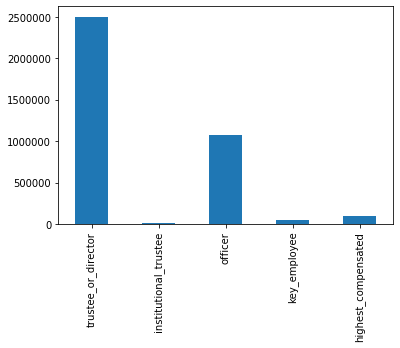

In [33]:
# what is the distribution
# based on the person receiving the compensation?
df.iloc[:, 3:8].notnull().sum().plot(kind='bar')

Trustee or director is the position with the highest number of rows in the dataset.

In [45]:
# remove positions I will not focus on at this time
# df.drop(['institutional_trustee',
#          'officer',
#          'key_employee',
#          'highest_compensated'], axis=1, inplace=True)

In [50]:
# how many trustees or directors
# received at least some compensation 
# in 2017?
df[(df.trustee_or_director == True) &
  (df.reportable_comp > 0) &
  (df.period.apply(lambda x: str(x)[0:4]) == '2017')
  ].shape

(40178, 15)

In [48]:
# subset dataset to focus analysis
df = df[(df.trustee_or_director == True) &
  (df.reportable_comp > 0) &
  (df.period.apply(lambda x: str(x)[0:4]) == '2017')
  ]

In [46]:
# examine data types
df.dtypes

ein                      int64
period                   int64
title                   object
trustee_or_director     object
reportable_comp        float64
org_name                object
subsection              object
ntee_code               object
ntee_description        object
state                   object
formation_yr           float64
assets                   int64
liabilities            float64
expenses               float64
revenue                float64
dtype: object

In [51]:
# examine for nan values
df.isna().sum()

ein                       0
period                    0
title                   268
trustee_or_director       0
reportable_comp           0
org_name                  0
subsection                0
ntee_code                81
ntee_description         81
state                   115
formation_yr           2253
assets                    0
liabilities               0
expenses                  0
revenue                   0
dtype: int64

In [52]:
# drop rows with missing values in these columns
df.dropna(subset=['ntee_code'], inplace=True)

C:\Users\mrkjh\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [53]:
df.shape

(40097, 15)

In [56]:
# the small percentage of missing values 
# in these columns is acceptable to me
df.isna().mean()

ein                    0.000000
period                 0.000000
title                  0.006684
trustee_or_director    0.000000
reportable_comp        0.000000
org_name               0.000000
subsection             0.000000
ntee_code              0.000000
ntee_description       0.000000
state                  0.002868
formation_yr           0.054767
assets                 0.000000
liabilities            0.000000
expenses               0.000000
revenue                0.000000
dtype: float64

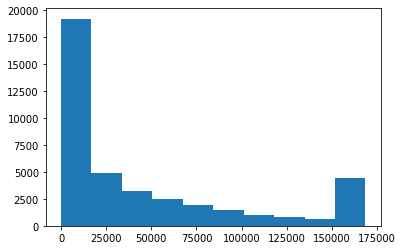

In [57]:
# clipping at the 90% percentile, what is the distribution?
plt.hist(df.reportable_comp.clip(upper=df.reportable_comp.quantile(.9)));

In [58]:
df.reportable_comp.quantile(.9)

168533.60000000003

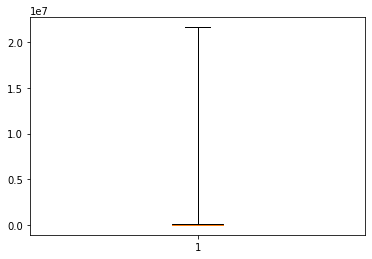

In [59]:
plt.boxplot(df.reportable_comp, whis='range');

## FEATURE ENGINEERING

In [60]:
# to more broadly categorize not-for-profits
# strip off the letter from the ntee code
df['ntee_letter'] = df.ntee_code.apply(lambda x: x[0:1])

C:\Users\mrkjh\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [61]:
# based on ntee letters, which orgs have the most variance?
df.groupby('ntee_letter')['reportable_comp'].var() \
    .sort_values(ascending=False).reset_index()

,ntee_letter,reportable_comp
0,E,4.111779e+11
1,S,9.364884e+10
2,U,4.897066e+10
3,H,4.833287e+10
4,G,2.673913e+10
5,A,2.629700e+10
6,W,2.608796e+10
7,N,1.940259e+10
8,Q,1.643159e+10
9,V,1.625188e+10


In [62]:
df.head()

,ein,period,title,trustee_or_director,reportable_comp,org_name,subsection,ntee_code,ntee_description,state,formation_yr,assets,liabilities,expenses,revenue,ntee_letter
6,10877614,201712,BOARD MEMBER/MANAGING D,True,55385.0,HEART CHANGE MINISTRIES INC,501(c)(3),G43,"Heart and Circulatory System Diseases, Disorders",IN,2006.0,2112293,92283.0,500749.0,1792933.0,G
7,10877614,201712,BOARD MEMBER,True,60000.0,HEART CHANGE MINISTRIES INC,501(c)(3),G43,"Heart and Circulatory System Diseases, Disorders",IN,2006.0,2112293,92283.0,500749.0,1792933.0,G
154,10884383,201712,PRESIDENT,True,71062.0,MILAGRE KIDS SCHOOLS INC,501(c)(3),B28,Specialized Education Institutions,PA,2007.0,97123,13093.0,1251188.0,1294636.0,B
158,10884383,201712,VICE PRESIDENT,True,9010.0,MILAGRE KIDS SCHOOLS INC,501(c)(3),B28,Specialized Education Institutions,PA,2007.0,97123,13093.0,1251188.0,1294636.0,B
459,10906593,201712,VP OF FINANC,True,87452.0,MANAGEMENT SERVICES INC,501(c)(3),S02,Management and technical assistance - Communit...,CA,2008.0,4161179,120847.0,881055.0,795668.0,S


## EDA

### NTEE type analysis

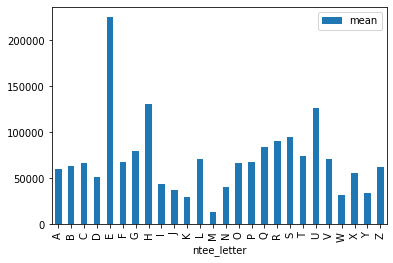

In [68]:
# which ntee category receives the highest executive compensation
df.groupby('ntee_letter')['reportable_comp'].agg(['mean']).plot(kind='bar')

Type E (genearl health organizations, such as hospitals) have the highest salary associated with it.

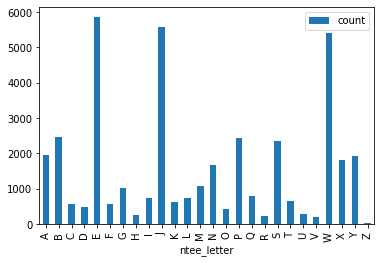

In [71]:
# which ntee category receives the highest executive compensation
df.groupby('ntee_letter')['reportable_comp'].agg(['count']).plot(kind='bar')

### 501(c) type analysis

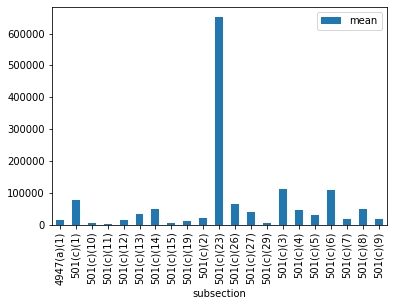

In [69]:
# based on not-for-profit type, which executives receive the highest compensation?
df.groupby('subsection')['reportable_comp'].agg(['mean']).plot(kind='bar')

501(c)(23) executives receive the highest compensation by a lot.

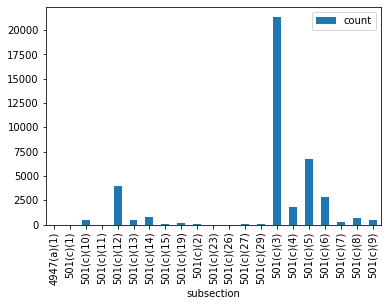

In [70]:
# count distribution by not-for-profit type?
df.groupby('subsection')['reportable_comp'].agg(['count']).plot(kind='bar')

501(c)(3) has the highest number of organizations by a lot.

### Title analysis
This is a fill in the blank field, as a result there are a huge number of unique values.

In [73]:
df.title.nunique()

7035

In [72]:
df.title.value_counts()

DIRECTOR                               5518
PRESIDENT                              2353
Director                               2170
TRUSTEE                                1702
BOARD MEMBER                           1507
                                       ... 
CHAPTER MANA                              1
PRESIDENT/CEO (THRU 2/18)                 1
ASST. SECRETARY, PV GENERAL COUNSEL       1
BUSINESS MGR.                             1
DirectorAssistantTrainer                  1
Name: title, Length: 7035, dtype: int64

### SPARE PARTS